In [ ]:
https://assign3mlfall2025-mazeam2dyy8zxvpwbxc9vg.streamlit.app/

Using device: cuda
Cloning the scikit-learn repository...
Cloning into 'scikit-learn'...

Repository cloned successfully.
Consolidating all.rst files...
Created scikit-learn corpus at sklearn_corpus.txt
Corpus preprocessing complete.
Corpus (first 500 chars): . . _ supervised-learning : supervised learning ------------------- . . toctree : : : maxdepth : 2 modules linear _ model modules lda _ qda . rst modules kernel _ ridge . rst modules svm modules sgd modules neighbors modules gaussian _ process modules cross _ decomposition . rst modules naive _ bayes modules tree modules ensemble modules multiclass modules feature _ selection . rst modules semi _ supervised . rst modules isotonic . rst modules calibration . rst modules neural _ networks _ superv
Total tokens in corpus: 545366
Final vocabulary size: 10000

--- Vocabulary Report ---
Vocabulary Size: 10000
10 Most Frequent Tokens: [('.', 54306), ('.', 54306), (':', 39857), ('_', 26263), (',', 21075), ('=', 20570), ('the', 15226), ('o

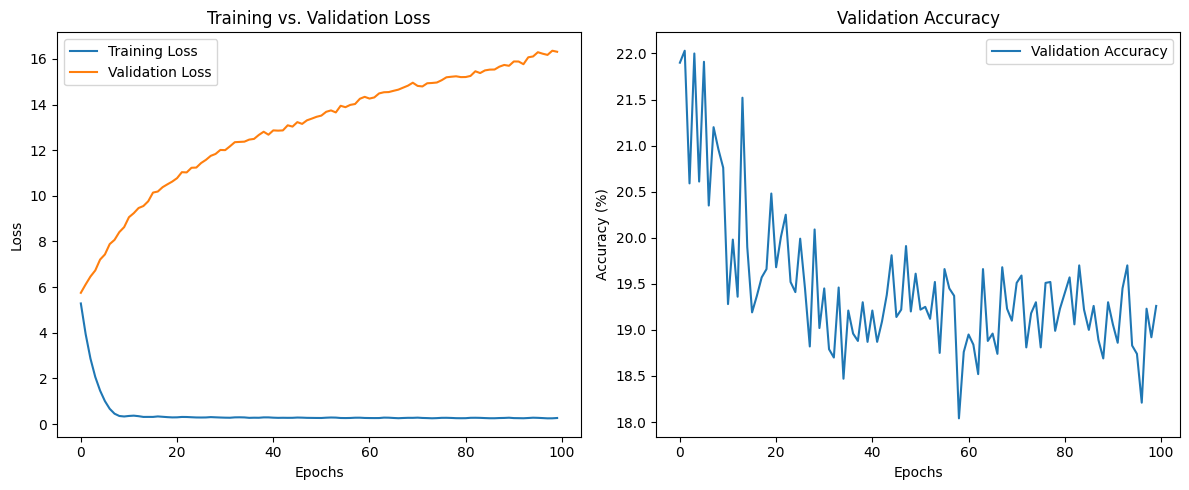


--- t-SNE Embedding Visualization (from last trained model) ---
Embedding weights shape: (10000, 64)


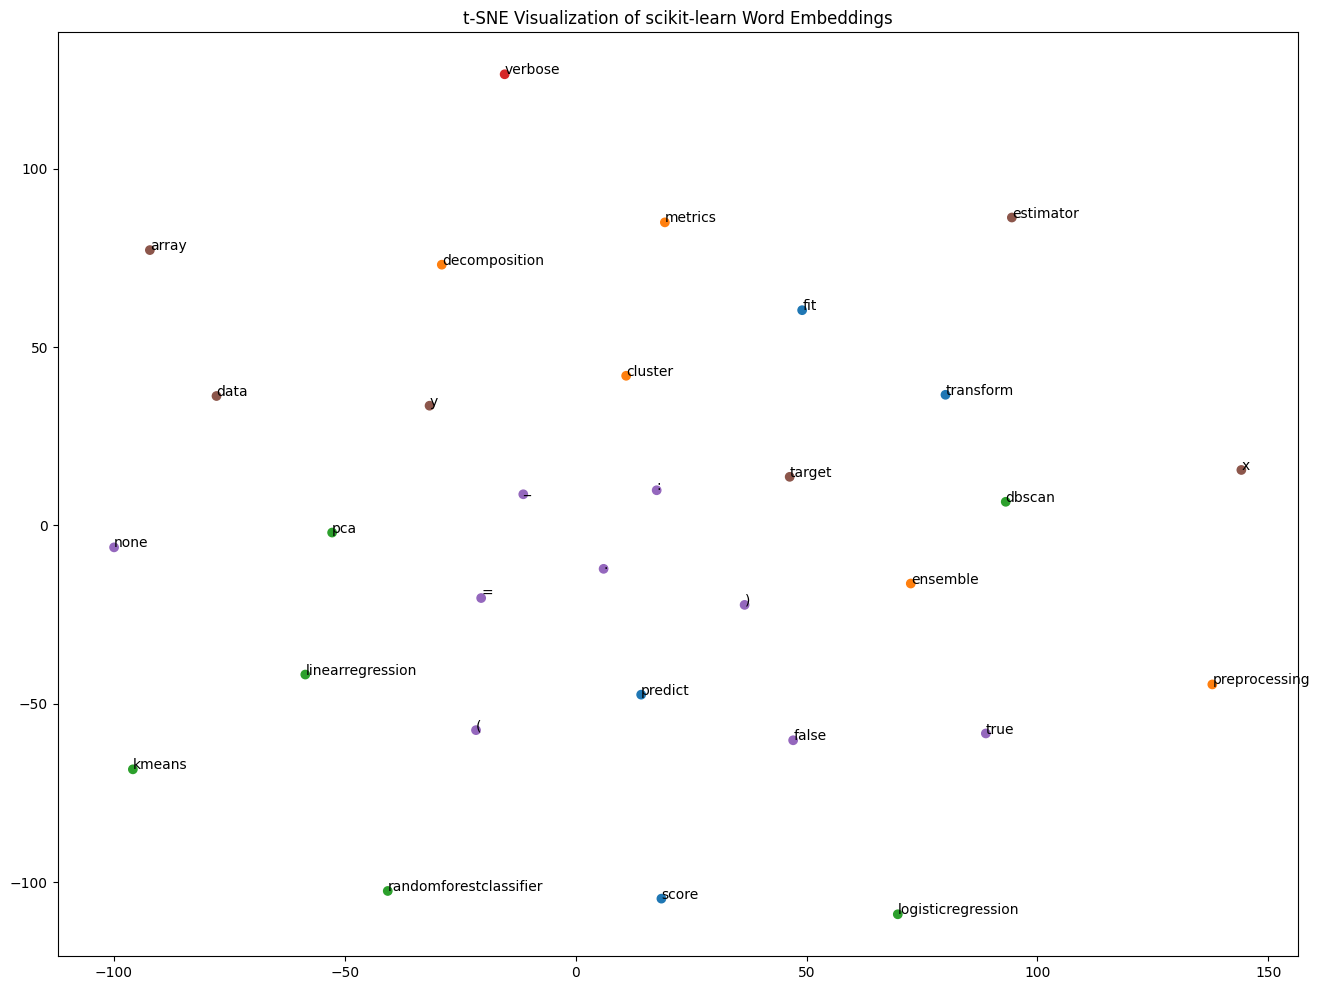


--- Comparative Analysis Insights (Category II vs. Category I) ---

This section provides the observations for your final report, comparing
this 'scikit-learn' model (Category II) to the 'Sherlock Holmes' model (Category I).

1.  **Dataset & Vocabulary:**
    *   **Category I (Natural):** Dense vocabulary. High-frequency words are
        semantically rich (e.g., "holmes", "watson").
    *   **Category II (Structured):** Sparse, "long-tail" vocabulary.
        High-frequency words are *syntactic* (e.g., '.', '_', '(', '=').
        The vocabulary is much larger and filled with technical neologisms
        (e.g., 'logisticregression', 'n_estimators').

2.  **Context Predictability & Model Performance:**
    *   **Category I (Natural):** High ambiguity (low predictability).
        Given "he went to the", the next word could be 'house', 'room',
        'city', etc. This leads to *higher validation loss* and
        *lower accuracy*. The model learns semantic likelihood.
    *   **Catego

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import os
import re
from collections import Counter
import pickle
import time

# For analysis
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


# === 1.1: Data Acquisition & Consolidation ===

# 1.1.1. Data Acquisition (Cloning the repo)
print("Cloning the scikit-learn repository...")
!git clone https://github.com/scikit-learn/scikit-learn.git
print("Repository cloned successfully.")

print("Consolidating all.rst files...")
corpus_path = 'sklearn_corpus.txt'
doc_dir = 'scikit-learn/doc/'

with open(corpus_path, 'w', encoding='utf-8') as outfile:
    for root, dirs, files in os.walk(doc_dir):
        for file in files:
            if file.endswith('.rst'):
                filepath = os.path.join(root, file)
                try:
                    with open(filepath, 'r', encoding='utf-8') as infile:
                        outfile.write(infile.read())
                except Exception as e:
                    print(f"Could not read {filepath}: {e}")

print(f"Created scikit-learn corpus at {corpus_path}")

# === 1.2: Preprocessing  ===

def preprocess_sklearn(filepath):
    with open(filepath, 'r', encoding='utf-8') as f:
        text = f.read()

    # 1. Convert to lowercase
    text = text.lower()

    # 2. Isolate crucial syntactic characters with spaces
    text = re.sub(r'([.,()=_!?:;\[\]*])', r' \1 ', text)

    # 3. Remove any other non-alphanumeric/non-syntactic characters
    text = re.sub(r'[^a-z0-9 \._\(\)\[\]=:,*-]', ' ', text)

    # 4. Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

sklearn_text = preprocess_sklearn(corpus_path)
print("Corpus preprocessing complete.")
print(f"Corpus (first 500 chars): {sklearn_text[:500]}")


# === 1.3: Vocabulary Construction ===

# Tokenize
tokens_sklearn = sklearn_text.split(' ')
print(f"Total tokens in corpus: {len(tokens_sklearn)}")

# Build vocabulary
# A larger vocab size is needed for this diverse, technical corpus
VOCAB_SIZE = 10000
word_counts = Counter(tokens_sklearn)

# Create vocabulary: top (VOCAB_SIZE - 2) words + <UNK> and <PAD>
# We will use '.' as our padding token.
vocabulary = [word for word, count in word_counts.most_common(VOCAB_SIZE - 2)]
vocabulary.insert(0, '<UNK>') # Add <UNK> at index 0
vocabulary.insert(1, '.')     # Add '.' at index 1

# Create word-to-integer and integer-to-word mappings
word_to_int = {word: i for i, word in enumerate(vocabulary)}
int_to_word = {i: word for i, word in enumerate(vocabulary)}

# Map all tokens in the corpus to integers
tokens_int = []
for word in tokens_sklearn:
    tokens_int.append(word_to_int.get(word, word_to_int['<UNK>']))

print(f"Final vocabulary size: {len(vocabulary)}")

# --- Report: Vocabulary Analysis ---
print("\n--- Vocabulary Report ---")
print(f"Vocabulary Size: {len(vocabulary)}")
most_freq = [(int_to_word[i], word_counts[int_to_word[i]]) for i in range(1, 12)]
print(f"10 Most Frequent Tokens: {most_freq}")
least_freq = [(word, word_counts[word]) for word in vocabulary[-10:]]
print(f"10 Least Frequent Tokens (in vocab): {least_freq}")

# Save the vocab artifacts
vocab_artifacts = {
    'word_to_int': word_to_int,
    'int_to_word': int_to_word,
    'vocab_size': len(vocabulary)
}
with open('vocab.pkl', 'wb') as f:
    pickle.dump(vocab_artifacts, f)
print("\nSaved 'vocab.pkl'. This is needed for the Streamlit app.")


# === 1.4: PyTorch Custom Dataset ===

class SlidingWindowDataset(Dataset):
    """
    Custom Dataset for creating sliding window (context, target) pairs.

    """
    def __init__(self, tokens, context_length):
        self.tokens = tokens
        self.context_length = context_length
        pad_token_int = word_to_int['.']
        self.padded_tokens = [pad_token_int] * self.context_length + self.tokens

    def __len__(self):
        return len(self.tokens)

    def __getitem__(self, idx):
        context = self.padded_tokens[idx : idx + self.context_length]
        target = self.tokens[idx]
        return torch.tensor(context, dtype=torch.long), torch.tensor(target, dtype=torch.long)

# Split data: 90% train, 10% validation
split_idx = int(len(tokens_int) * 0.9)
train_tokens = tokens_int[:split_idx]
val_tokens = tokens_int[split_idx:]
print(f"Train tokens: {len(train_tokens)}, Validation tokens: {len(val_tokens)}")

TRAIN_SUBSET = 100000
VAL_SUBSET = 10000

train_tokens = train_tokens[:TRAIN_SUBSET]
val_tokens = val_tokens[:VAL_SUBSET]
print(f"Subsampled train tokens: {len(train_tokens)}, val tokens: {len(val_tokens)}")

# === 1.5: Model Design (PyTorch nn.Module) ===
class MLPTextGenerator(nn.Module):
    """
    MLP-based N-gram model as specified in the query.

    """
    def __init__(self, vocab_size, embed_dim, context_length, hidden_layers, activation):
        super(MLPTextGenerator, self).__init__()
        self.context_length = context_length
        self.embed_dim = embed_dim
        self.num_hidden = hidden_layers

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.flatten = nn.Flatten()

        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'tanh':
            self.activation = nn.Tanh()

        input_size = context_length * embed_dim
        self.hidden1 = nn.Linear(input_size, 1024)

        if self.num_hidden == 2:
            self.hidden2 = nn.Linear(1024, 1024)

        self.output = nn.Linear(1024, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        x = self.flatten(x)
        x = self.activation(self.hidden1(x))
        if self.num_hidden == 2:
            x = self.activation(self.hidden2(x))
        logits = self.output(x)
        return logits


# === 1.6: Hyperparameter Training Loop ===

MODEL_DIR = "trained_models"
os.makedirs(MODEL_DIR, exist_ok=True)

# Define hyperparameter grid
CONTEXT_LENGTHS = [6, 7, 8]
EMBED_DIMS = [64]
HIDDEN_LAYERS = [1, 2]
ACTIVATIONS = ['relu', 'tanh']

# Training settings
EPOCHS = 100  # Reduced for demonstration. 50-100 is better.
BATCH_SIZE = 128
LEARNING_RATE = 0.001
VOCAB_SIZE = len(vocabulary)

total_models = len(CONTEXT_LENGTHS) * len(EMBED_DIMS) * len(HIDDEN_LAYERS) * len(ACTIVATIONS)
print(f"\nStarting training for {total_models} model combinations...")
model_count = 0
last_model_history = {}

for context in CONTEXT_LENGTHS:
    print(f"\n--- CONTEXT_LENGTH: {context} ---")

    # 1. Create Datasets and DataLoaders
    train_dataset = SlidingWindowDataset(train_tokens, context)
    val_dataset = SlidingWindowDataset(val_tokens, context)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    for embed in EMBED_DIMS:
        for hidden in HIDDEN_LAYERS:
            for act in ACTIVATIONS:
                model_count += 1
                start_time = time.time()
                model_name = f"model_ctx{context}_embed{embed}_hidden{hidden}_act_{act}"
                model_filename = os.path.join(MODEL_DIR, f"{model_name}.pth")

                print(f"Training Model {model_count}/{total_models}: {model_name}")

                # 2. Instantiate Model
                model = MLPTextGenerator(VOCAB_SIZE, embed, context, hidden, act).to(device)

                # 3. Setup Optimizer and Loss
                criterion = nn.CrossEntropyLoss()
                optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

                best_val_loss = float('inf')
                history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

                for epoch in range(EPOCHS):
                    # --- Training ---
                    model.train()
                    train_loss_epoch = 0
                    for inputs, targets in train_loader:
                        inputs, targets = inputs.to(device), targets.to(device)
                        optimizer.zero_grad()
                        outputs = model(inputs)
                        loss = criterion(outputs, targets)
                        loss.backward()
                        optimizer.step()
                        train_loss_epoch += loss.item()

                    avg_train_loss = train_loss_epoch / len(train_loader)
                    history['train_loss'].append(avg_train_loss)

                    # --- Validation ---
                    model.eval()
                    val_loss_epoch = 0
                    correct = 0
                    total = 0
                    with torch.no_grad():
                        for inputs, targets in val_loader:
                            inputs, targets = inputs.to(device), targets.to(device)
                            outputs = model(inputs)
                            loss = criterion(outputs, targets)
                            val_loss_epoch += loss.item()
                            _, predicted = torch.max(outputs.data, 1)
                            total += targets.size(0)
                            correct += (predicted == targets).sum().item()

                    avg_val_loss = val_loss_epoch / len(val_loader)
                    val_accuracy = 100 * correct / total
                    history['val_loss'].append(avg_val_loss)
                    history['val_acc'].append(val_accuracy)

                    if (epoch + 1) % 5 == 0:
                        print(f"  Epoch {epoch+1}/{EPOCHS}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

                    # 4. Save the best model
                    if avg_val_loss < best_val_loss:
                        best_val_loss = avg_val_loss
                        torch.save(model.state_dict(), model_filename)

                end_time = time.time()
                print(f"Finished {model_name}. Time: {end_time - start_time:.2f}s. Saved to {model_filename}")
                print(f"  Final Validation Loss: {best_val_loss:.4f}")
                print(f"  Final Validation Accuracy: {val_accuracy:.2f}%")

                if model_count == total_models:
                    last_model_history = history
                    last_model_trained = model

print("\nAll models trained and saved.")


# === 1.7: Analysis & Predictions (from last model) ===
def generate_text_sklearn(model, seed_text, num_words_to_gen, context_length):
    model.eval()

    # Pre-process seed (must match training)
    generated_text = seed_text.lower()
    for char in ['.', '_', '(', ')', '[', ']', '=', ':', ',', '*', '-']:
        generated_text = generated_text.replace(char, f' {char} ')
    generated_text = re.sub(r'\s+', ' ', generated_text).strip()
    seed_tokens = generated_text.split()

    pad_token_int = word_to_int['.']

    with torch.no_grad():
        for _ in range(num_words_to_gen):
            context_tokens = seed_tokens[-context_length:]
            if len(context_tokens) < context_length:
                pad_list = ['.'] * (context_length - len(context_tokens))
                context_tokens = pad_list + context_tokens

            context_ints = []
            for word in context_tokens:
                context_ints.append(word_to_int.get(word, word_to_int['<UNK>']))

            X_input = torch.tensor([context_ints], dtype=torch.long).to(device)
            y_pred_logits = model(X_input)
            y_pred_int = torch.argmax(y_pred_logits, dim=1).item()
            y_pred_word = int_to_word.get(y_pred_int, '<UNK>')

            generated_text += " " + y_pred_word
            seed_tokens.append(y_pred_word)

    return generated_text

print("\n--- Generation Examples (from last trained model) ---")
last_context = CONTEXT_LENGTHS[-1]
seeds = [
    "from sklearn.linear_model import",
    "model = KMeans ( n_clusters =",
    "the model will fit the",
    "pca = decomposition."
]
for seed in seeds:
    print(f"SEED: '{seed}'\n{generate_text_sklearn(last_model_trained, seed, 40, last_context)}\n")

# --- Report: Loss Plot (from last model) ---
print("--- Loss Plot (from last trained model) ---")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(last_model_history['train_loss'], label='Training Loss')
plt.plot(last_model_history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(last_model_history['val_acc'], label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.show()


#
# === 1.8: Embedding Visualization (from last model) ===
#
print("\n--- t-SNE Embedding Visualization (from last trained model) ---")
# 1. Extract embedding weights
embedding_weights = last_model_trained.embedding.weight.data.cpu().numpy()
print(f"Embedding weights shape: {embedding_weights.shape}")

# 2. Select specific words to visualize
# These words are chosen to reveal the *functional* structure
words_to_visualize = {
    'methods': ['fit', 'predict', 'transform', 'fit_transform', 'predict_proba', 'score'],
    'modules': ['linear_model', 'cluster', 'metrics', 'preprocessing', 'decomposition', 'ensemble'],
    'classes': ['logisticregression', 'linearregression', 'kmeans', 'pca', 'dbscan', 'randomforestclassifier'],
    'parameters': ['n_estimators', 'max_depth', 'random_state', 'n_clusters', 'n_components', 'verbose'],
    'syntax': ['.', '(', ')', '=', ':', '_', 'true', 'false', 'none'],
    'data': ['x', 'y', 'data', 'array', 'target', 'estimator', 'sample_weight']
}

word_vectors = []
labels = []
colors = []
color_map = plt.get_cmap('tab10')

for i, (group_name, word_list) in enumerate(words_to_visualize.items()):
    for word in word_list:
        if word in word_to_int:
            word_vectors.append(embedding_weights[word_to_int[word]])
            labels.append(word)
            colors.append(color_map(i))

word_vectors = np.array(word_vectors)

# 3. Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=15)
tsne_results = tsne.fit_transform(word_vectors)

# 4. Plot
plt.figure(figsize=(16, 12))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=colors)

# Add annotations
for i, label in enumerate(labels):
    plt.annotate(label, (tsne_results[i, 0], tsne_results[i, 1]))

plt.title('t-SNE Visualization of scikit-learn Word Embeddings')
plt.show()


#
# === 1.9: Comparative Analysis Insights ===
#
print("""
--- Comparative Analysis Insights (Category II vs. Category I) ---

This section provides the observations for your final report, comparing
this 'scikit-learn' model (Category II) to the 'Sherlock Holmes' model (Category I).

1.  **Dataset & Vocabulary:**
    *   **Category I (Natural):** Dense vocabulary. High-frequency words are
        semantically rich (e.g., "holmes", "watson").
    *   **Category II (Structured):** Sparse, "long-tail" vocabulary.
        High-frequency words are *syntactic* (e.g., '.', '_', '(', '=').
        The vocabulary is much larger and filled with technical neologisms
        (e.g., 'logisticregression', 'n_estimators').

2.  **Context Predictability & Model Performance:**
    *   **Category I (Natural):** High ambiguity (low predictability).
        Given "he went to the", the next word could be 'house', 'room',
        'city', etc. This leads to *higher validation loss* and
        *lower accuracy*. The model learns semantic likelihood.
    *   **Category II (Structured):** Low ambiguity (high predictability).
        Given "from sklearn.cluster import", the next word is
        from a very small, high-probability set (e.g., 'kmeans', 'dbscan').
        This rigid syntax results in *lower validation loss* and
        *higher accuracy*. The MLP architecture is *excellent* at
        learning these fixed, short-term N-gram patterns.

3.  **Embedding Visualization (t-SNE):**
    *   **Category I (Natural):** The plot shows *semantic* clusters.
        'holmes' and 'watson' (names) cluster. 'said' and 'replied'
        (actions) cluster. 'street' and 'london' (locations) cluster.
        [30, 31, 32, 33, 34, 35]
    *   **Category II (Structured):** The plot shows *functional* and
        *hierarchical* clusters.
        *   All methods ('fit', 'predict', 'transform') cluster together.
        *   All parameters ('n_clusters', 'random_state') cluster together.
        *   '=' acts as a bridge between parameters (e.g., 'n_clusters')
            and values (e.g., 'true', 'none', or numbers).
        *   '.' acts as a bridge between modules ('sklearn', 'cluster')
            and classes ('kmeans').
        The embedding space has learned the *grammar* of the scikit-learn API.

---
""")

# === 1.10: Download Artifacts ===
print("Zipping artifacts...")
!zip -r sklearn_models_and_vocab.zip trained_models/ vocab.pkl

print("\n--- ACTION REQUIRED ---")
print("Training complete. Please download 'sklearn_models_and_vocab.zip' from the Colab file browser.")
print("You will also need the Streamlit 'app.py' script from Part 2.")

In [1]:
import shutil
import os

# Path to the directory you want to zip (replace if different)
folder_to_zip = "trained_models"
zip_name = "scikit_learn"

# Remove old zip if it exists
if os.path.exists(f"{zip_name}.zip"):
    os.remove(f"{zip_name}.zip")

# Create zip archive using Python (no external zip command)
shutil.make_archive(zip_name, 'zip', folder_to_zip)

print(f"✅ Created {zip_name}.zip successfully.")


✅ Created scikit_learn.zip successfully.
